## Notebook to compare scaling with respect to system size

We consider both graphene and a nanoribbon to compare the effect of dimensionality.

Note that this assumes the existence of certain files already, including nanoribbon .xyz files, template support functions with the appropriate name, and .png files illustrating each material. 

Similarly, the linear scaling calculations used to plot the matrices and the calculations used to generate the DoS for each setup are also run separately.  That is, the calculations used for the timing are for a ground state calculation without any unecessary writing of files, or diagonalization (linear)/optimization of virtual states (cubic). 

The relevant files are provided but not directly generated from the notebook.

In [1]:
from BigDFT import Logfiles as lf
from BigDFT import Fragments as F
import numpy as np
import colours
import graphene
import ribbon
from futile import YamlIO as Y
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mpc
import matplotlib.ticker as ticker
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
mpl.rc("savefig", dpi=400)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

import pandas as pd
from IPython.display import display

In [2]:
inputs = {}
systems = ['ribbon', 'graphene']
for system in systems:
    inputs[system] = {}
    inputs[system]['short_names'] = []
    inputs[system]['seeds'] = []
    inputs[system]['atoms'] = []

First we create the positions for the nanoribbon - actually since it has been optimized elsewhere,  the replicate_ribbon.sh script is used instead - this could be integrated in future.  Therefore, we assume the .xyz exist already, an the following serves just to setup some other variables.

In [3]:
# create a nanoribbon
width = [30, 30]
bond = 2.6
bondi = [2.6,2.68]
nhex = 4
pad = 15.0
fwseed = []

# the number of units are selected to give similar system sizes to graphene
# values for nw = 1
nunits = [6, 32, 54, 110, 162]
natm1 = 0
natsr = []
for nunit in nunits:
    anchor = 0.5*np.array([width[0],width[1],bond])
    cell_dims,ribbon_pos = graphene.build_ribbon(nunit,anchor,bondi,bond,nhex,pad)
    #bcs = 'periodic '+str(cell_dims[0])+' '+str(cell_dims[1])+' '+str(cell_dims[2])    
    bcs = 'surface '+str(cell_dims[0])+' '+str(0.0)+' '+str(cell_dims[2])   
    #bcs = 'free'
    nat = len(ribbon_pos)
    natsr.append(nat)
    print nunit, nat, nat - natm1
    seed = 'ribbon_'+str(nunit)
    inputs['ribbon']['short_names'].append(str(nunit))
    filename = seed+'.xyz'
    inputs['ribbon']['seeds'].append(seed)
    inputs['ribbon']['atoms'].append(nat)
    #F.dump_xyz(ribbon_pos,basename='C',units='atomic',filename=filename,position='w',comment=bcs)
    natm1 = nat
    
fwseed.append(systems[0]+'_'+str(nunits[0])+'_fw')

6 108 108
32 576 468
54 972 396
110 1980 1008
162 2916 936


Now we generate the .xyz files for graphene

In [4]:
#generate the posinps
ixs = [i for i in range(7,38,3)]
ixs = [7, 16, 21, 29, 35]
seeds = []
short_names =[]
natm1 = 0
natsg = []
for ix in ixs:
    # keep the x and z dimensions similar
    iz = int(ix*0.6)
    cell_dims,graphene_pos = graphene.build_graphene(ix,iz)
    bcs = 'surface '+str(cell_dims[0])+' 0.00000 '+str(cell_dims[2])
    nat = len(graphene_pos)
    print ix, iz, nat, nat - natm1 #cell_dims[0], cell_dims[2], 
    natsg.append(nat)
    seed = 'graphene_'+str(ix)+'_'+str(iz)
    inputs['graphene']['short_names'].append(str(ix)+'_'+str(iz))
    filename = seed+'.xyz'
    inputs['graphene']['seeds'].append(seed)
    inputs['graphene']['atoms'].append(nat)
    F.dump_xyz(graphene_pos,basename='C',units='atomic',filename=filename,position='w',comment=bcs)
    natm1 = nat
    
fwseed.append(systems[1]+'_'+str(ixs[0])+'_'+str(int(ixs[0]*0.6))+'_fw')

7 4 112 112
16 9 576 464
21 12 1008 432
29 17 1972 964
35 21 2940 968


Now we generate the .yaml files for each system - they should have the same parameters, just different position files.

Note that the template support function generation is done elsewhere, the following assumes that they already exist.  Could also be integrated with the notebook in future.

In [5]:
# generate the cubic yaml files
ixc = 'PBE'
hgrids = 0.45
rmult = [5,7]
# we use a different dictionary for the ribbon, since the cubic approach otherwise has a negative gap
cubic_dict = {'dft': {'ixc': ixc, 'disablesym': True, 'rmult': rmult, 'hgrids': hgrids, 'gnrm_cv': 1.e-4,
                     'idsx': 4}} 
             # 'import': 'mixing', 'mix': {'norbsempty': 0, 'rpnrm_cv': 1.e-10}}

for system in systems:
    ss = system[0]
    for s, seed in enumerate(inputs[system]['seeds']):
        filename = seed+'_cubic.yaml'
        #if system == 'ribbon':
        #    cubic_dict['mix'].update({'norbsempty': nunits[s]*3})   
        #else:
        #    cubic_dict['mix'].update({'norbsempty': inputs[system]['atoms'][s]/4})
        cubic_dict.update({'posinp': seed})
        Y.dump(cubic_dict,filename)

    inputs[system]['snc'] = []
    for short_name in inputs[system]['short_names']:
        inputs[system]['snc'].append(ss+'cub'+short_name)

    inputs[system]['sc'] = []
    for seed in inputs[system]['seeds']:
        inputs[system]['sc'].append(seed+'_cubic')
    
    graphene.list_to_bash(inputs[system]['sc'],'seeds')
    graphene.list_to_bash(inputs[system]['snc'],'short_names')

seeds=("ribbon_6_cubic" "ribbon_32_cubic" "ribbon_54_cubic" "ribbon_110_cubic" "ribbon_162_cubic" )
short_names=("rcub6" "rcub32" "rcub54" "rcub110" "rcub162" )
seeds=("graphene_7_4_cubic" "graphene_16_9_cubic" "graphene_21_12_cubic" "graphene_29_17_cubic" "graphene_35_21_cubic" )
short_names=("gcub7_4" "gcub16_9" "gcub21_12" "gcub29_17" "gcub35_21" )


In [6]:
# generate the linear yaml files
linear_dict = {'import': 'linear_moderate', 
               'dft': {'ixc': ixc, 'disablesym': True, 'hgrids': hgrids, 'rmult': rmult},
               'perf': {'calculate_KS_residue': False, 'store_index': True, 'hamapp_radius_incr': 6,
                        'adjust_kernel_threshold': False, 'adjust_kernel_iterations': False},
               'lin_general': {'nit': 100, 'rpnrm_cv': 1.0e-11, 'taylor_order': 1010},
                #, 'output_mat': 11, 'subspace_diag': True},
               'lin_basis': {'nit': 3, 'idsx': 2, 'gnrm_ig': 1.e-2, 'gnrm_cv': 2.e-3},
               'lin_kernel': {'nit': 4, 'idsx': 2, 'alphamix': 0.1, 'rpnrm_cv': 1.0e-10},
               'lin_basis_params': {'rloc_kernel': 10, 'rloc_kernel_foe': 12,
                                    'C': {'nbasis': 4, 'rloc': 7.0}}}
for system in systems:
    ss = system[0]
    for seed in inputs[system]['seeds']:
        filename = seed+'_linear.yaml'
        linear_dict.update({'posinp': seed})
        Y.dump(linear_dict,filename)
    
    inputs[system]['snl'] = []
    for short_name in inputs[system]['short_names']:
        inputs[system]['snl'].append(ss+'lin'+short_name)
    
    inputs[system]['sl'] = []
    for seed in inputs[system]['seeds']:
        inputs[system]['sl'].append(seed+'_linear')
    
    graphene.list_to_bash(inputs[system]['sl'],'seeds')
    graphene.list_to_bash(inputs[system]['snl'],'short_names')

seeds=("ribbon_6_linear" "ribbon_32_linear" "ribbon_54_linear" "ribbon_110_linear" "ribbon_162_linear" )
short_names=("rlin6" "rlin32" "rlin54" "rlin110" "rlin162" )
seeds=("graphene_7_4_linear" "graphene_16_9_linear" "graphene_21_12_linear" "graphene_29_17_linear" "graphene_35_21_linear" )
short_names=("glin7_4" "glin16_9" "glin21_12" "glin29_17" "glin35_21" )


In [7]:
# generate the fragment read yaml files
fr_dict = {'import': 'linear_moderate', 
               'dft': {'ixc': ixc, 'disablesym': True, 'hgrids': hgrids, 'rmult': rmult,
                      'inputpsiid': 'linear_restart'},
               'perf': {'calculate_KS_residue': False, 'store_index': True, 'hamapp_radius_incr': 6,
                        'adjust_kernel_threshold': False, 'adjust_kernel_iterations': False,
                        'experimental_mode': False},
               'lin_general': {'hybrid' : False, 'nit': 1, 'taylor_order': 1010},
               'lin_basis': {'nit': 1},
               'lin_kernel': {'nit': [0,200], 'idsx': 4, 'alphamix': 0.1, 'rpnrm_cv': 1.0e-10},
               'lin_basis_params': {'rloc_kernel': 10, 'rloc_kernel_foe': 12,
                                    'C': {'nbasis': 4, 'rloc': 7.0}}}
for system in systems:
    ss = system[0]
    for s,seed in enumerate(inputs[system]['seeds']):
        filename = seed+'_fr.yaml'
        fr_dict.update({'posinp': seed})
        fr_dict.update({'radical': system+'_fw'})
        if system == 'ribbon':
            w = natsr[s] / 18
        elif system == 'graphene':
            w = natsg[s] / 4
        fdict = {ss+'frag': [f for f in range(1,w+1)]} 
        rfrag_dict = {'frag': fdict}
        fr_dict.update(rfrag_dict)
        Y.dump(fr_dict,filename)
    
    inputs[system]['snf'] = []
    for short_name in inputs[system]['short_names']:
        inputs[system]['snf'].append(ss+'fr'+short_name)
    
    inputs[system]['sf'] = []
    for seed in inputs[system]['seeds']:
        inputs[system]['sf'].append(seed+'_fr')
    
    graphene.list_to_bash(inputs[system]['sf'],'seeds')
    graphene.list_to_bash(inputs[system]['snf'],'short_names')

seeds=("ribbon_6_fr" "ribbon_32_fr" "ribbon_54_fr" "ribbon_110_fr" "ribbon_162_fr" )
short_names=("rfr6" "rfr32" "rfr54" "rfr110" "rfr162" )
seeds=("graphene_7_4_fr" "graphene_16_9_fr" "graphene_21_12_fr" "graphene_29_17_fr" "graphene_35_21_fr" )
short_names=("gfr7_4" "gfr16_9" "gfr21_12" "gfr29_17" "gfr35_21" )


Pause here if needed after the creation of the input files, calculations must be run elsewhere then the following is used to post-process the logfiles.

In [8]:
#assert False

In [9]:
def set_plot_parameters(ax, xmin, xmax, ymin, ymax, xlabel, ylabel, xtlabel, ytlabel,
                        dx, dy, nmx, nmy, shrink, key_loc): 

    if xmin != 'DEFAULT':
        ax.set_xlim(xmin, xmax)
    if ymin != 'DEFAULT':
        ax.set_ylim(ymin, ymax)
    
    if xlabel != 'NONE':
        ax.set_xlabel(xlabel)
        
    if ylabel != 'NONE':
        ax.set_ylabel(ylabel)

    pad = 8
    mjl = 6
    mnl = 3

    if xtlabel == 'NOLABEL':
        label = False
    else:
        label = True
        
    if dx == 'NONE':
        ax.get_xaxis().set_ticks([])
    else:
        ax.tick_params(axis='x', which='major', direction='in', pad=pad, length=mjl,
                   bottom=True, top=True, labelbottom=label, labeltop=False)
        ax.tick_params(axis='x', which='minor', direction='in', pad=pad, length=mnl,
                   bottom=True, top=True, labelbottom=label, labeltop=False)

    if ytlabel == 'NOLABEL':
        label = False
    else:
        label = True
    
    if dy == 'NONE':
        ax.get_yaxis().set_ticks([])
    else:
        ax.tick_params(axis='y', which='major', direction='in', pad=pad, length=mjl,
                    left=True, right=True, labelleft=label, labelright=False)
        ax.tick_params(axis='y', which='minor', direction='in', pad=pad, length=mnl,
                   left=True, right=True, labelleft=label, labelright=False)
    
    if dx != 'DEFAULT' and dx != 'NONE':
        ax.xaxis.set_major_locator(ticker.MultipleLocator(dx))
        if nmx != 'DEFAULT':
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(dx / nmx))
    if dy != 'DEFAULT' and dy != 'NONE':
        ax.yaxis.set_major_locator(ticker.MultipleLocator(dy))
        if nmy != 'DEFAULT':  
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(dy / nmy))
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * shrink, box.height])
    
    if key_loc == 'outside':
        ax.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))
    elif key_loc != 'NONE':
        ax.legend(loc=key_loc, ncol=1)

In [10]:
# lists of markers and colors to be used for plots
colors_rgb = [[0, 0, 0], [143, 143, 143], [255, 0, 0], [54, 101, 255], [54, 255, 101]]
colors_rgb = [[0, 0, 0], [143, 143, 143], [88, 24, 69], [199, 13, 57], [255, 87, 51]]
colors = []
for rgb in colors_rgb:
    html = colours.rgb_to_html(rgb)
    colors.append(html)
    
colors_rainbow = colours.find_colours(8)

markers = ['s', 'o', '^', 'v', 'd', 'p', 'h', 'D']
widths = [2, 2, 2]
sizes = [8, 8, 8]

In [11]:
# define convergence function for fitting
def poly3(t, a, b, c):
    #c = 0
    return a*np.power(t,3) + b*np.power(t,2) + c*np.power(t,1)

def poly1(t, c):
    return c*np.power(t,1)

In [12]:
def crossover(ac, bc, cc, al):
    tc1 = (-bc + np.sqrt(np.power(bc,2) - 4.0*ac*(cc - al)))/(2.0*ac)
    tc2 = (-bc - np.sqrt(np.power(bc,2) - 4.0*ac*(cc - al)))/(2.0*ac)
    #print -bc, np.sqrt(np.power(bc,2)), 4.0*ac*(cc - al), 2.0*ac
    return [tc1, tc2]

In [13]:
all_data = {}
for system in systems:
    all_data[system] = [graphene.find_basic_data(inputs[system]['seeds'], 'cubic'),
                graphene.find_basic_data(inputs[system]['seeds'], 'linear'),
                graphene.find_basic_data(inputs[system]['seeds'], 'fr')]

In [14]:
# print the error as a check to make sure the different sizes are of similar quality
for s,system in enumerate(systems):
    for d, data in enumerate(all_data[system][0]['energies']):  
        #print d, len(all_data[system][0]), len(all_data[system][1])
        ec = all_data[system][0]['energies'][d]
        el = all_data[system][1]['energies'][d]
        ef = all_data[system][2]['energies'][d]
        error = 1000 * (el - ec)
        errorf = 1000 * (ef - ec)
        print system, all_data[system][0]['atoms'][d], error, errorf

ribbon 108 5.97635483865 5.97647531461
ribbon 576 10.2357257412 10.2904074311
ribbon 972 15.1653422769 11.949491408
graphene 112 10.7176872798 13.9319277512
graphene 576 11.39466235 15.176323886
graphene 1008 10.7913793685 14.0363523336


In [15]:
# also need to include cost of template calculation
for s,system in enumerate(systems):
    lname = 'log-'+fwseed[s]+'.yaml'
    log = lf.Logfile(lname)
    fw_time = log.log['Timings for root process']['Elapsed time (s)']/60.0
    #print lname, fw_time
    for d, data in enumerate(all_data[system][2]['etime']):
        all_data[system][2]['etime'][d] += fw_time

In [16]:
# create some more data points for the fitted curves
atoms = [a for a in range(0,5000,50)]
numsys = len(systems)
# set the plotting range
amin = 0
#amax = all_data[1]['atoms'][-1] + 50
amax = 3000

/home/lr408/.local/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


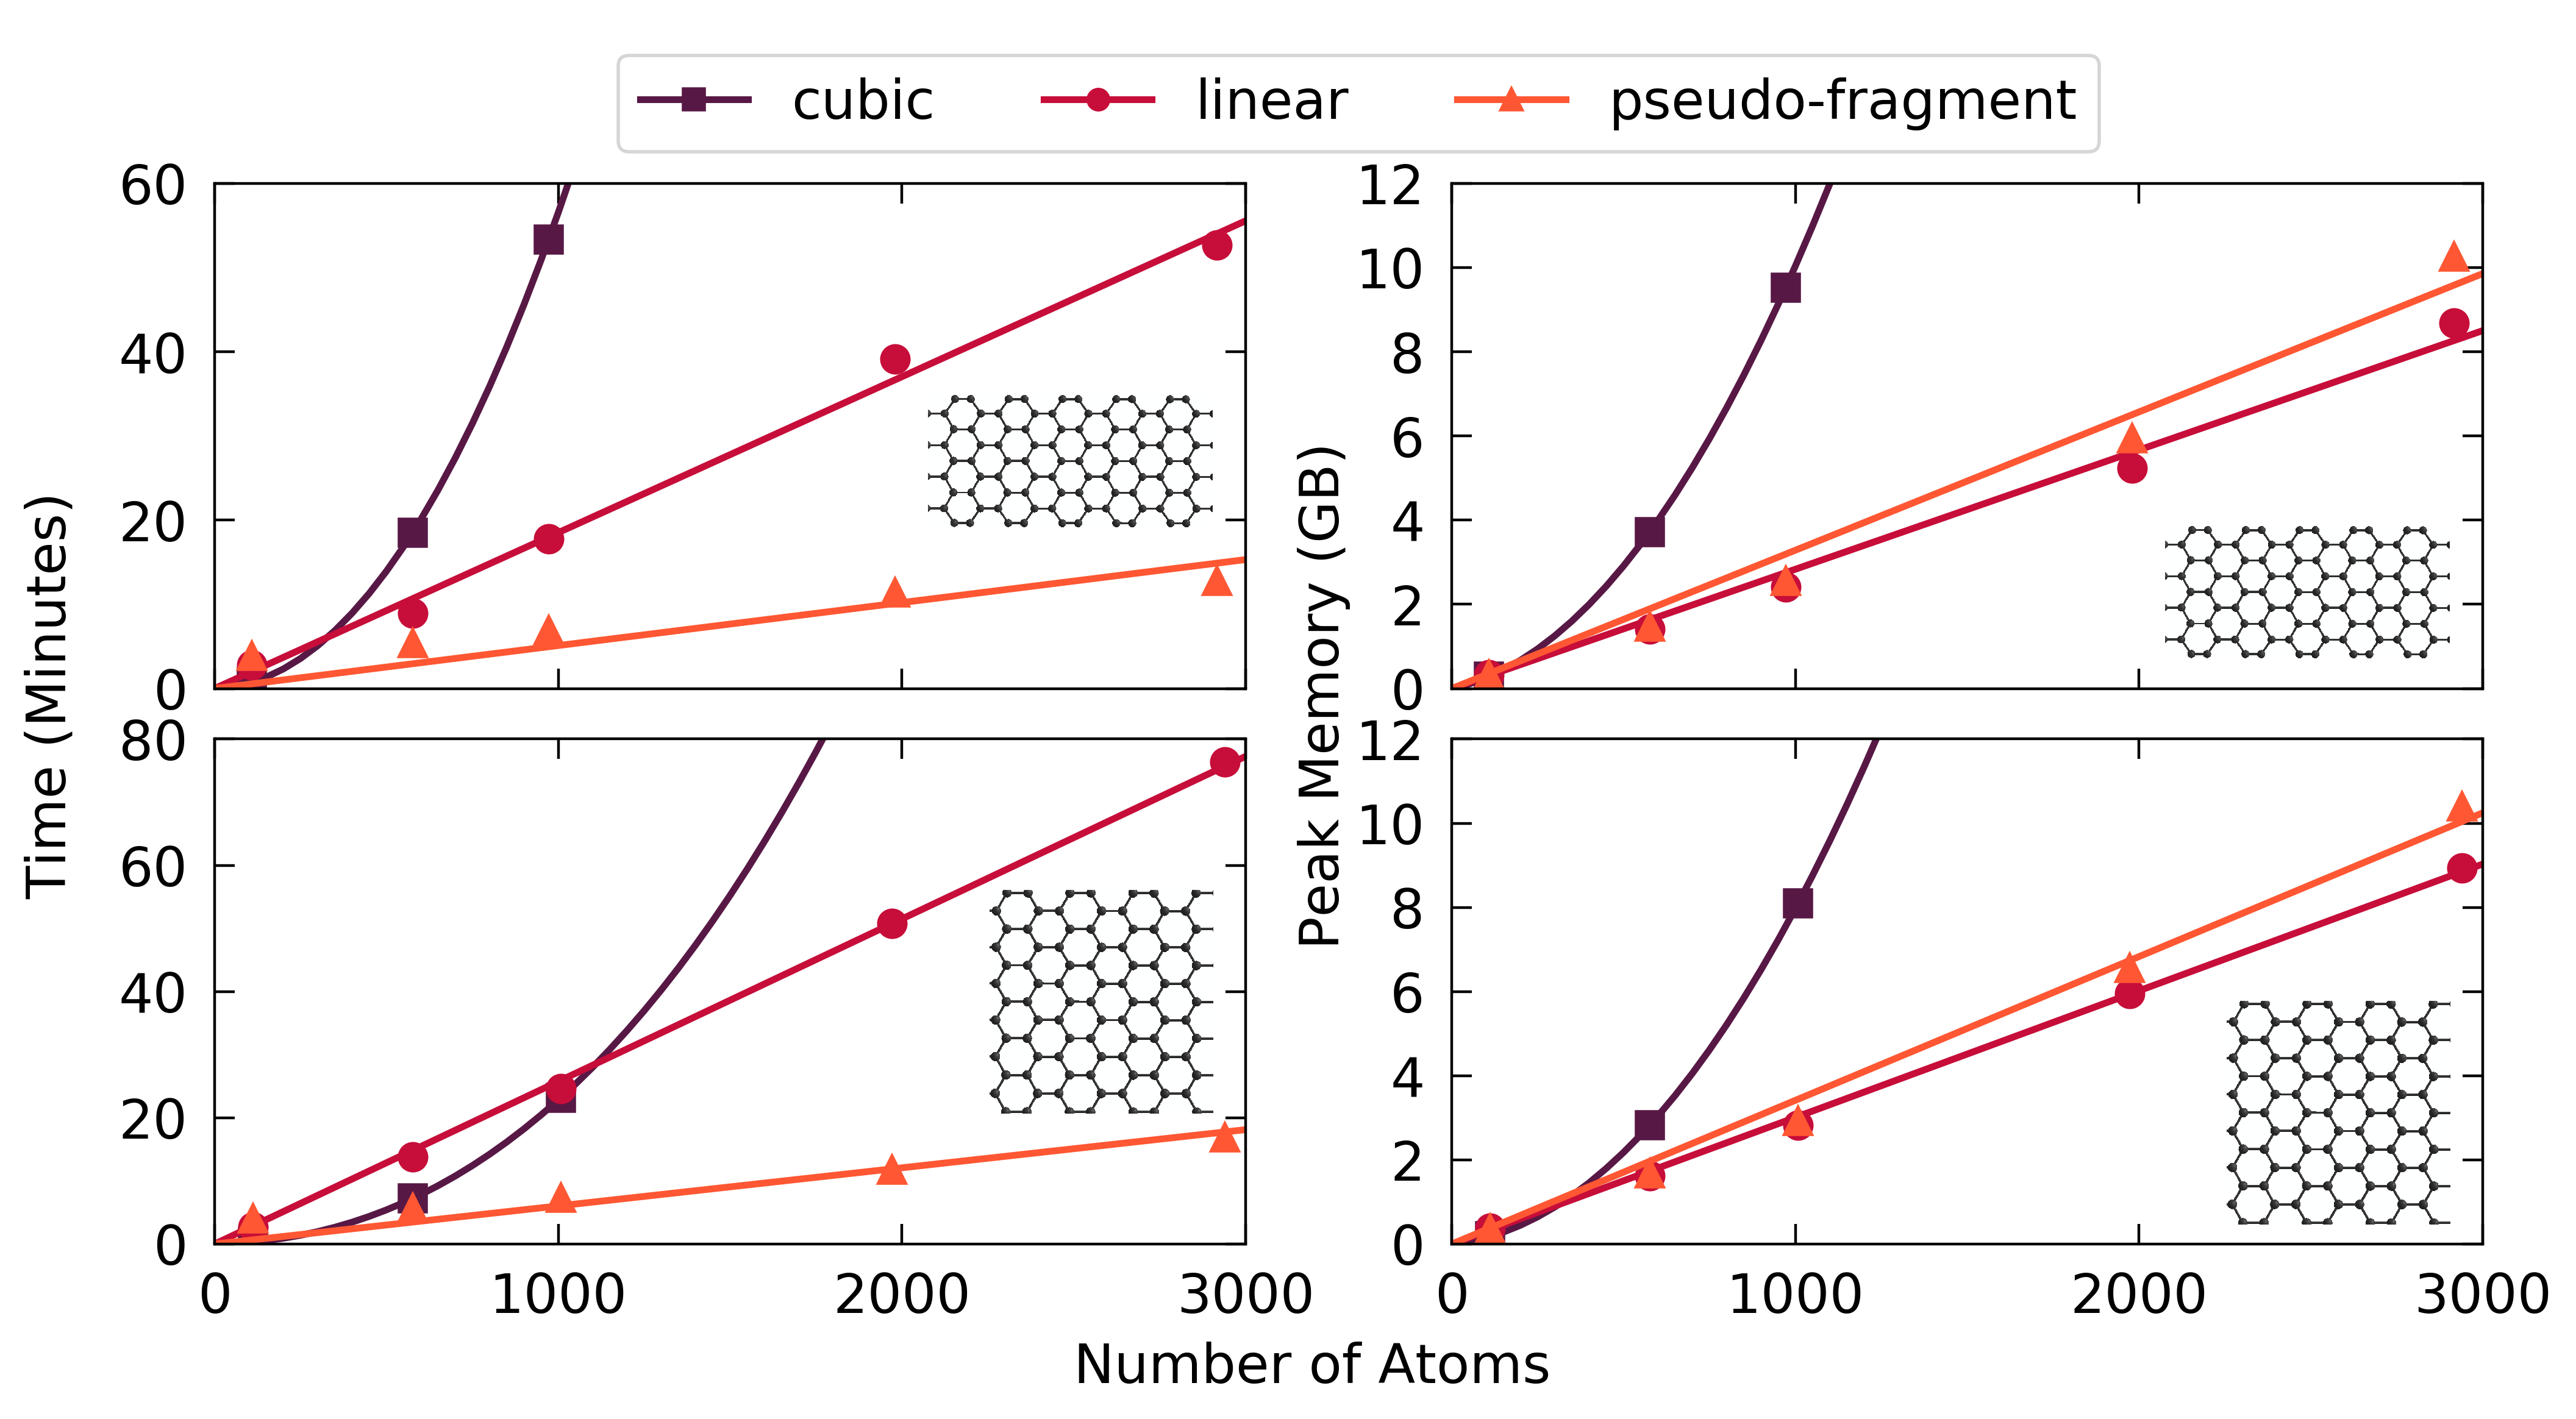

In [17]:
images = ['rib6.png', 'graphene_7_4.png']

tmin = 0
#tmax = max(all_data[0]['etime'][-1],all_data[1]['ctime'][-1]) + 5.0
tmax = [60, 80]

# plot atoms vs. memory
mmin = 0
#mmax = max(all_data[0]['ctime'][-1],all_data[1]['memory'][-1]) + 5.0
mmax = 12 #10.67

da = 1000
dm = 2
dt = 20

z = [0.07,0.055]
x = [0.83, 0.86]
yt = [0.45, 0.48]
ym = [0.19, 0.26]

nlabel = "Number of Atoms"
tlabel = "Time (Minutes)"
mlabel = "Peak Memory (GB)"

#gs = gridspec.GridSpec(numsys, 2, width_ratios=[1, 1]) 
#plt.figure(figsize=(10,9))
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(2, 2, sharex='col', figsize=(12,6))
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.2)
fig.text(0.5, 0.03, nlabel, ha='center')
fig.text(0.06, 0.5, tlabel, va='center', rotation='vertical')
fig.text(0.495, 0.5, mlabel, va='center', rotation='vertical')

ls = []
cross = {}

# time 
for s,system in enumerate(systems):
    cross[system] = {'time': [], 'memory': []}
    #ax = plt.subplot(gs[s,0])
    #plt.title("Time scaling for "+system)
    #plt.xlabel(nlabel)
    #plt.ylabel(tlabel)
    for d, data in enumerate(all_data[system]):
        ax[s][0].plot(data['atoms'], data['etime'],
            marker=markers[d], ls='', ms=sizes[d], label='', color=colors[d+2])
        if d==0:
            poptc, pcov = curve_fit(poly3, data['atoms'], data['etime'], bounds=(0,np.inf))
            lab = data['label']+': '+'{0:.0e}'.format(poptc[0])+'N'+u'\u00B3'+'+'\
                +'{0:.0e}'.format(poptc[1])+'N'+u'\u00B2'\
                +'+'+'{0:.0e}'.format(poptc[2])+'N'
            lab = 'cubic'
            l = ax[s][0].plot(atoms, poly3(atoms, *poptc),
                marker='', ls='-', lw=widths[d], label=lab, color=colors[d+2])
            if s == 0:
                l = ax[s][0].plot([0], [-10],
                    marker=markers[d], ls='-', lw=widths[d], label=lab, color=colors[d+2])
                ls.append(l)
        else:
            poptl, pcov = curve_fit(poly1, data['atoms'], data['etime'], bounds=(0,np.inf))
            lab = data['label']+': '+'{0:.0e}'.format(poptl[0])+'N'
            if d==1:
                lab = 'linear'
            else:
                lab = 'pseudo-fragment'
            l = ax[s][0].plot(atoms, poly1(atoms, *poptl),
                marker='', ls='-', lw=widths[d], label=lab, color=colors[d+2])
            tcross = crossover(poptc[0], poptc[1], poptc[2], poptl[0])
            cross[system]['time'].append('{0:.0f}'.format(tcross[0]))
            if s == 0:
                l = ax[s][0].plot([0], [-10],
                    marker=markers[d], ls='-', lw=widths[d], label=lab, color=colors[d+2])
                ls.append(l)
    
    img = plt.imread(images[s])
    imagebox = OffsetImage(img, zoom=z[s])
    imagebox.image.axes = ax[s][0]
    xy = [amax*x[s], tmax[s]*yt[s]]
    ab = AnnotationBbox(imagebox, xy, xycoords='data', frameon=False)
    ax[s][0].add_artist(ab)
    
    if s == 0: 
        set_plot_parameters(ax[s][0], amin, amax, tmin, tmax[s], 'NONE', 'NONE', 'NOLABEL', 'DEFAULT',
                da, dt, 'DEFAULT', 'DEFAULT', 1.0, 'NONE') 
    else:    
        set_plot_parameters(ax[s][0], amin, amax, tmin, tmax[s], 'NONE', 'NONE', 'DEFAULT', 'DEFAULT',
                da, dt, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')    
    
# memory
for s,system in enumerate(systems):
    for d, data in enumerate(all_data[system]):
        ax[s][1].plot(data['atoms'], data['memory'],
            marker=markers[d], ls='', ms=sizes[d], label='', color=colors[d+2])
        if d==0:
            poptc, pcov = curve_fit(poly3, data['atoms'], data['memory'], bounds=(0,np.inf))
            lab = data['label']+': '+'{0:.0e}'.format(poptc[0])+'N'+u'\u00B3'+'+'\
                +'{0:.0e}'.format(poptc[1])+'N'+u'\u00B2'\
                +'+'+'{0:.0e}'.format(poptc[2])+'N'
            ax[s][1].plot(atoms, poly3(atoms, *poptc),
                marker='', ls='-', lw=widths[d], label=lab, color=colors[d+2])
        else:
            poptl, pcov = curve_fit(poly1, data['atoms'], data['memory'], bounds=(0,np.inf))
            lab = data['label']+': '+'{0:.0e}'.format(poptl[0])+'N'
            ax[s][1].plot(atoms, poly1(atoms, *poptl),
                marker='', ls='-', lw=widths[d], label=lab, color=colors[d+2])
            mcross = crossover(poptc[0], poptc[1], poptc[2], poptl[0])
            mc = mcross[0]
            mcs = '{0:.0f}'.format(mc)
            # if it can't find the correct crossover (e.g. due to too small fitting coefficients)
            # then find value numerically rather than analytically
            if mc<=0:
                # first check if crossover is below first point
                if data['memory'][0] < all_data[system][0]['memory'][0]:
                    mcs = '<'+str(data['atoms'][0])
                else:
                    for a in range(1,amax):
                        #print a, poly1(a, *poptl), poly3(a, *poptc)
                         if poly1(a, *poptl) < poly3(a, *poptc):
                            mc = a
                            mcs = '{0:.0f}'.format(mc)
                            break
            cross[system]['memory'].append(mcs)

    img = plt.imread(images[s])
    imagebox = OffsetImage(img, zoom=z[s])
    imagebox.image.axes = ax[s][1]
    xy = [amax*x[s], mmax*ym[s]]
    ab = AnnotationBbox(imagebox, xy, xycoords='data', frameon=False)
    ax[s][1].add_artist(ab)

    if s == 0:
        set_plot_parameters(ax[s][1], amin, amax, mmin, mmax, 'NONE', 'NONE', 'NOLABEL', 'DEFAULT',
                da, dm, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')
    else:
        set_plot_parameters(ax[s][1], amin, amax, mmin, mmax, 'NONE', 'NONE', 'DEFAULT', 'DEFAULT',
                da, dm, 'DEFAULT', 'DEFAULT', 1.0, 'NONE')        

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.24,0.893], ncol=3)
plt.subplots_adjust(top=0.85)
    
#plt.tight_layout()    
plt.show()   

In [18]:
# add table with crossover values - fragment should also include the cost of template calc as a 2nd column

#print cross
arrays = [np.hstack([ ['Time']*2, ['Memory']*2]), [systems[0], systems[1]]*2]
columns = pd.MultiIndex.from_arrays(arrays, names=['', ''])

row_labels = ['linear', 'pseudo-fragment']

table_data = [[cross[systems[0]]['time'][0], cross[systems[1]]['time'][0], 
              cross[systems[0]]['memory'][0], cross[systems[1]]['memory'][0]],
             [cross[systems[0]]['time'][1], cross[systems[1]]['time'][1], 
              cross[systems[0]]['memory'][1], cross[systems[1]]['memory'][1]]]
        
df = pd.DataFrame(table_data, columns=columns, index=row_labels)
df.dtypes     
d = dict(selector="th", props=[('text-align', 'left')])
display(df)


Time          Memory         
                ribbon graphene ribbon graphene
linear             329     1111    136      310
pseudo-fragment     76      273    191      367

In [19]:
# add table with crossover values - fragment should also include the cost of template calc as a 2nd column

#print cross
arrays = [np.hstack([ [systems[0]]*2, [systems[1]]*2 ]), ['time', 'memory']*2]
columns = pd.MultiIndex.from_arrays(arrays, names=['', ''])

row_labels = ['linear', 'pseudo-fragment']

table_data = [[cross[systems[0]]['time'][0], cross[systems[0]]['memory'][0], 
                cross[systems[1]]['time'][0], cross[systems[1]]['memory'][0]],
             [cross[systems[0]]['time'][1], cross[systems[0]]['memory'][1], 
                cross[systems[1]]['time'][1], cross[systems[1]]['memory'][1]]]
        
df = pd.DataFrame(table_data, columns=columns, index=row_labels)
df.dtypes     
d = dict(selector="th", props=[('text-align', 'left')])
display(df)

ribbon        graphene       
                  time memory     time memory
linear             329    136     1111    310
pseudo-fragment     76    191      273    367

Plot the kernel for each system for a single size, to demonstrate accuracy

In [20]:
# take the 2nd size - 32, 16_9
# could make .yaml files automatically, but since it's just one was easier to copy
# just need output_mat:11 and subspace_diag: True
# also re-run cubic with Davidson
idos = [1, 1]

In [21]:
sf_mats = {}
for s, system in enumerate(systems):
    seed = inputs[system]['seeds'][idos[s]]
    sf_mats[system] = {}
    sf_mats[system]['k'] = graphene.read_sf_matrix('data-'+seed+'_lmp/density_kernel.bin')
    # to avoid large file sizes we only examine the kernel,
    # but the other matrices could be processed in the same way
    #sf_mats[system]['h'] = graphene.read_sf_matrix('data-'+seed+'_lmp/hamiltonian.bin')
    #sf_mats[system]['s'] = graphene.read_sf_matrix('data-'+seed+'_lmp/overlap.bin')

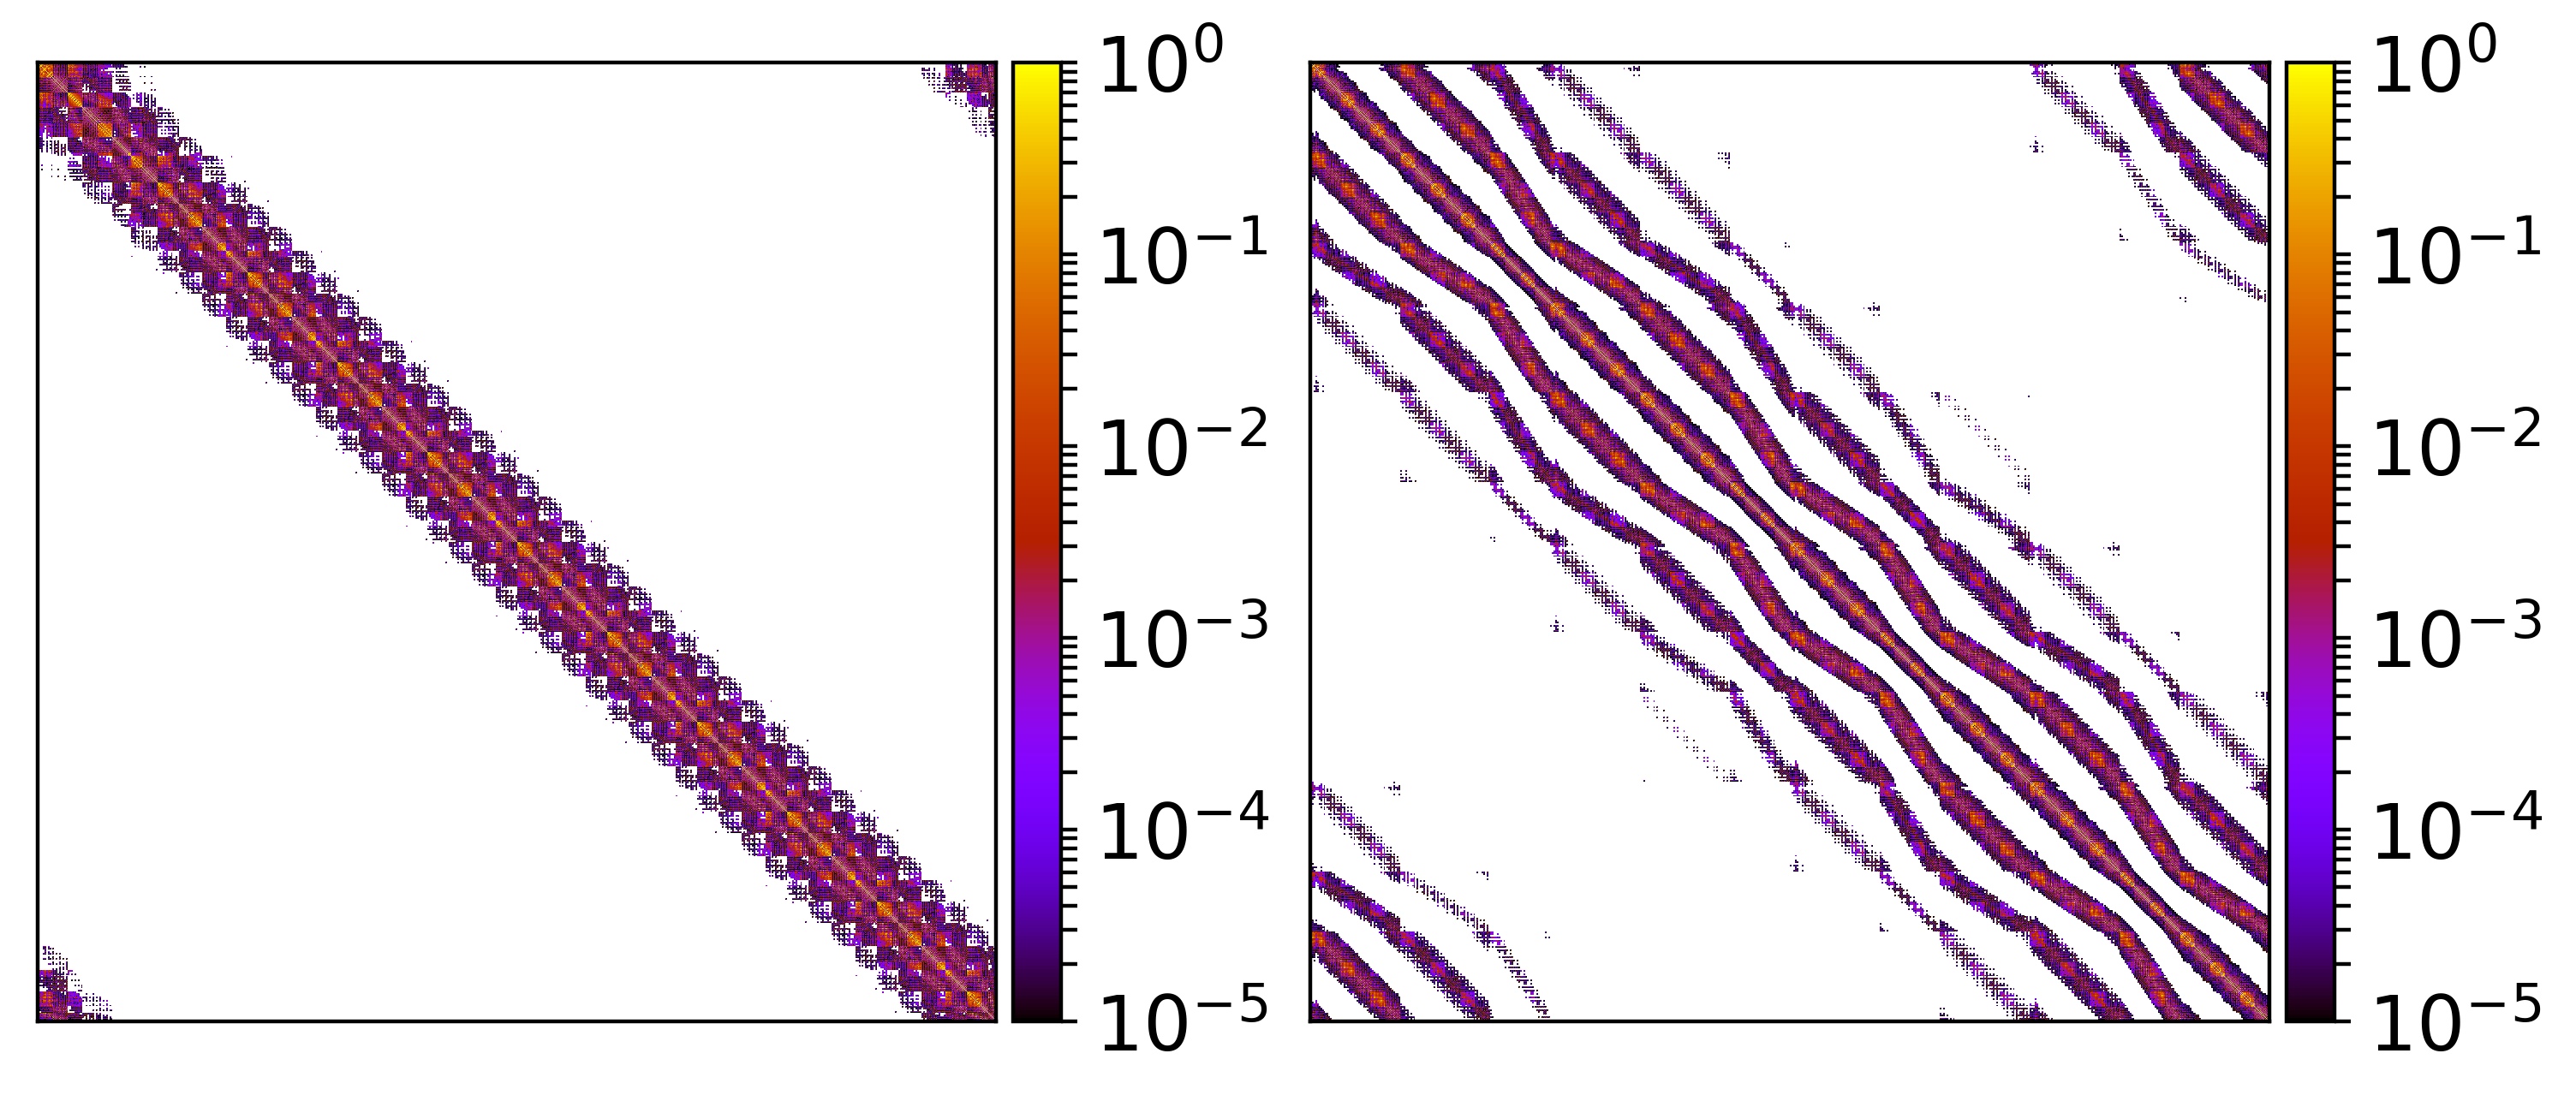

In [22]:
gs = gridspec.GridSpec(1, numsys, width_ratios=[1, 1]) 
plt.figure(figsize=(7.5,7.5))
plt.rcParams.update({'font.size': 16})

for s,system in enumerate(systems):
    nat = all_data[system][1]['atoms'][idos[s]]
    
    ax = plt.subplot(gs[s])
    #plt.title("$|\mathbf{K}|$ for "+str(nat)+" atom "+system)
    plt.imshow(sf_mats[system]['k'], norm=mpc.LogNorm(1.e-5,1), cmap='gnuplot')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=-5.0)   
plt.show()

Finally plot the DoS for each system for a single size, to demonstrate accuracy

In [23]:
smear = 0.25
dos_data = {}
for s,system in enumerate(systems):
    seed = inputs[system]['seeds'][idos[s]]
    dos_data[system] = [graphene.find_one_dos(seed, 'cmp', smear),
                        graphene.find_one_dos(seed, 'lmp', smear),
                        graphene.find_one_dos(seed, 'frmp', smear)]

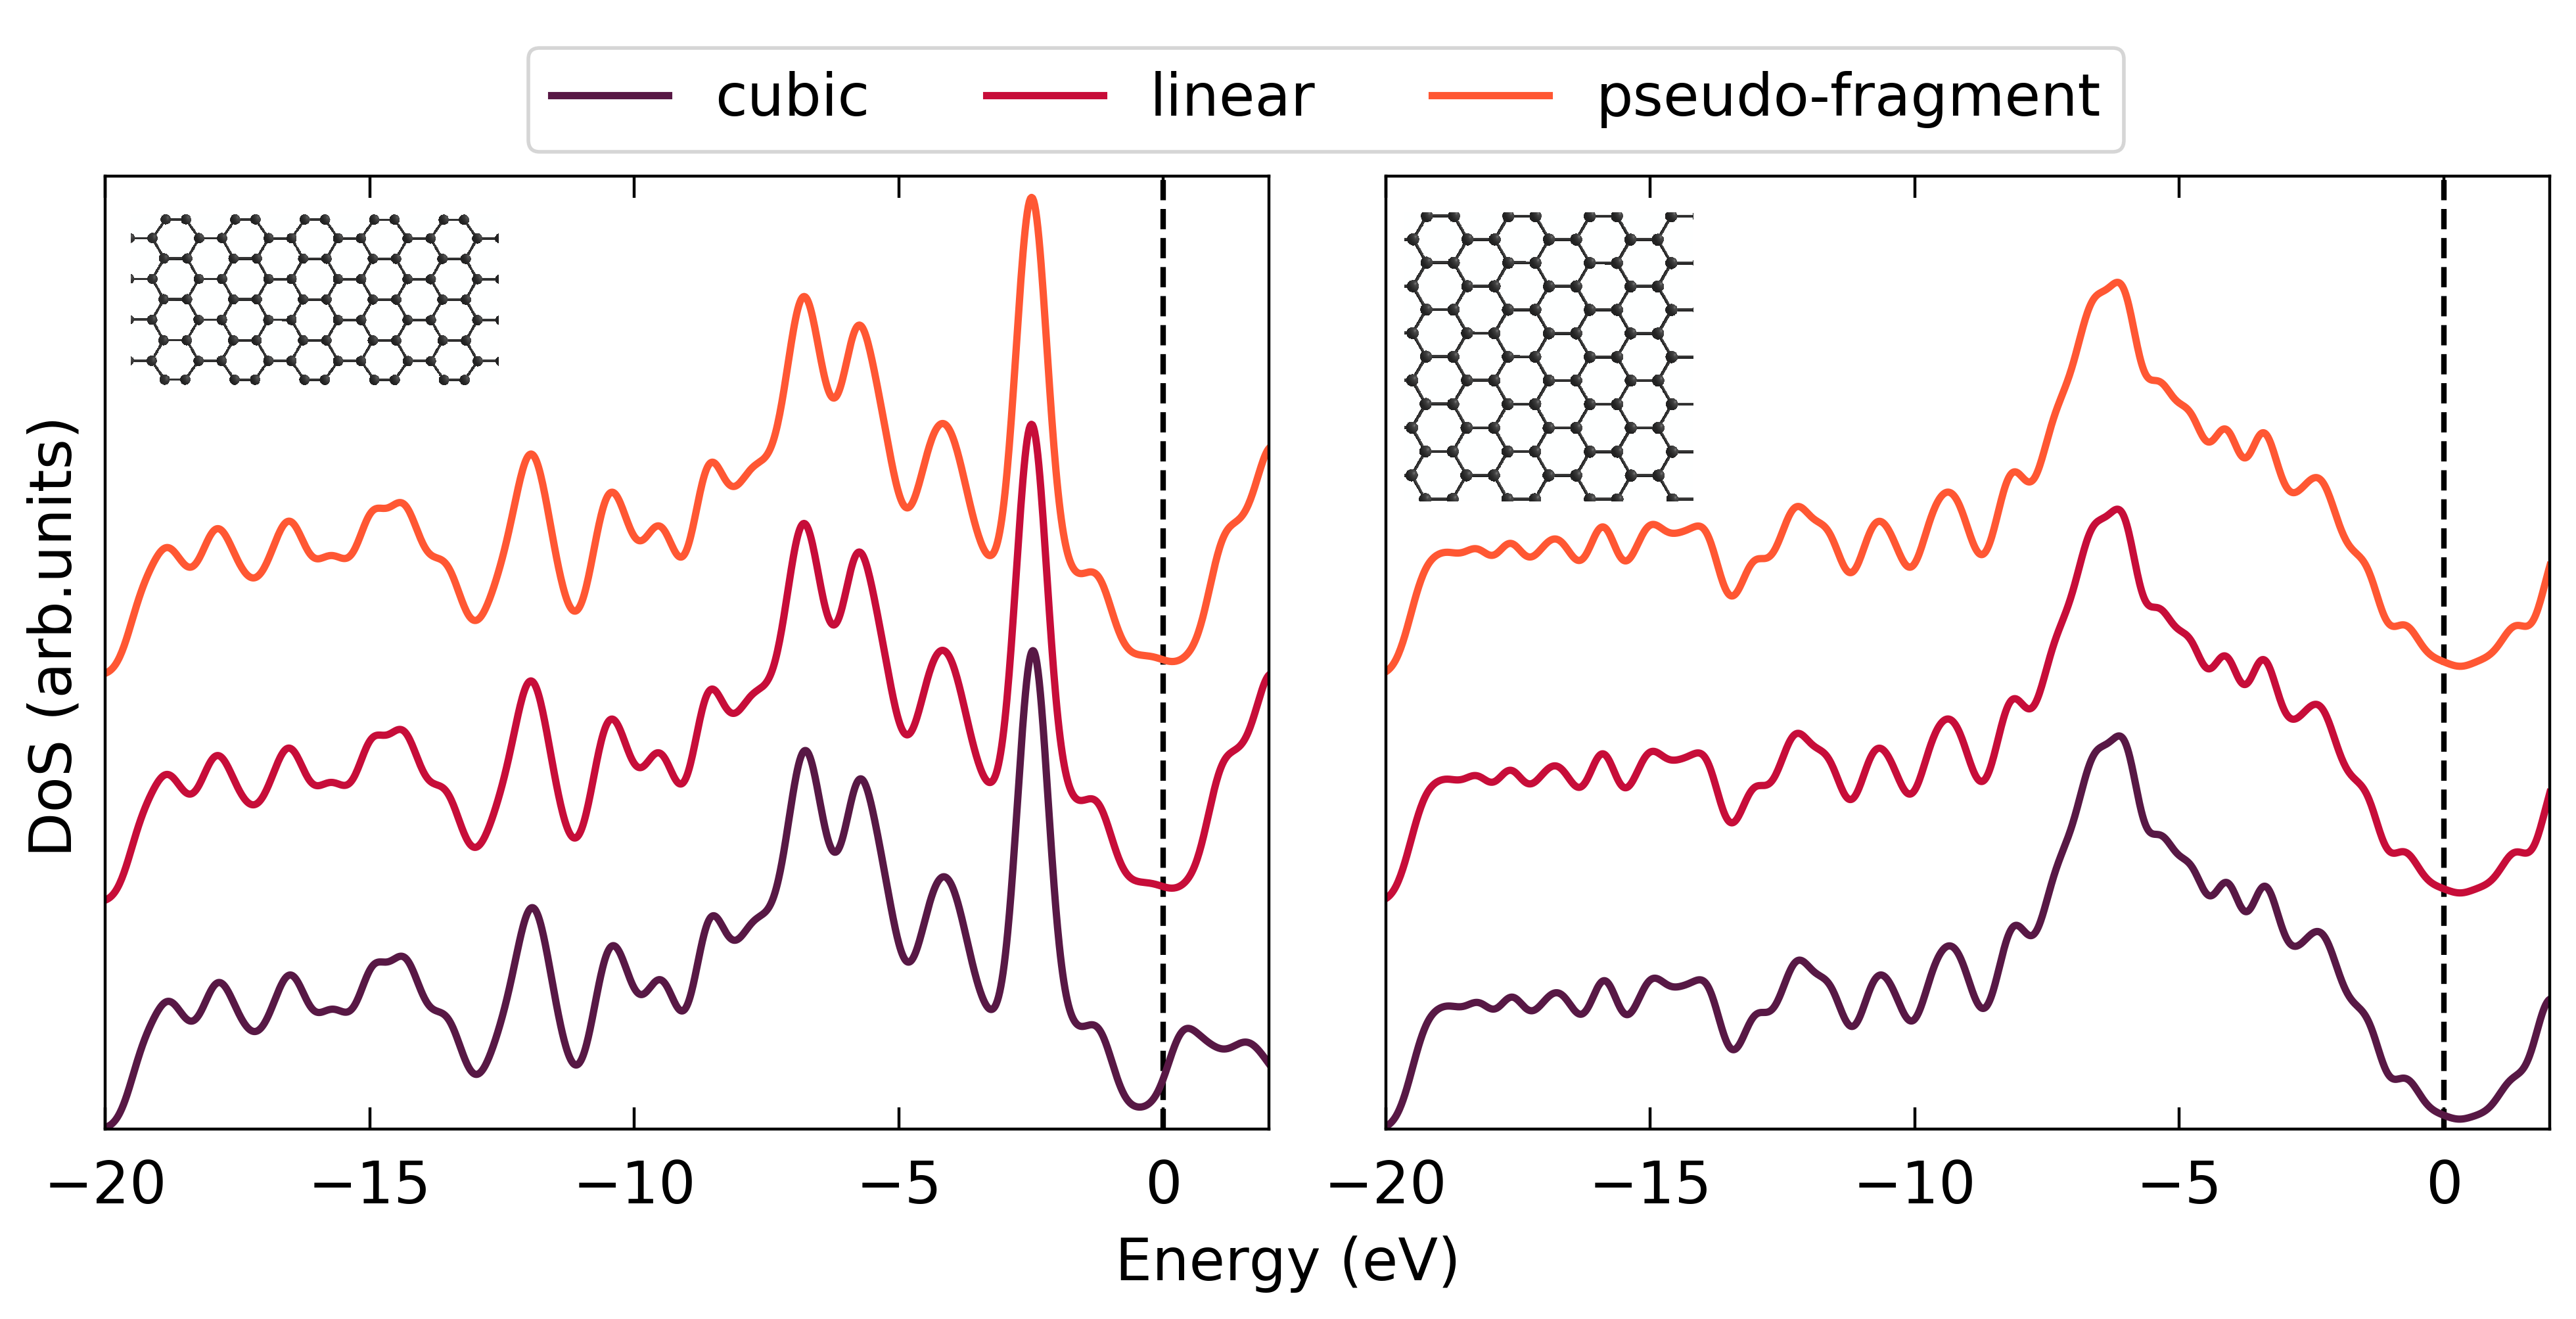

In [24]:
images = ['rib6.png', 'graphene_7_4.png']

# plot DoS
emin = -20
emax = 2
dmin = 0
de = 5
dy = 80
dmax = [160 + 2.2*dy, 160 + 2.2*dy]

z = [0.084, 0.066]
x = [0.18, 0.14]
y = [0.87, 0.81]

elabel = "Energy (eV)"
dlabel = "DoS (arb.units)"

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0.1)
fig.text(0.5, 0.01, elabel, ha='center')
fig.text(0.1, 0.5, dlabel, va='center', rotation='vertical')

ls = []

for s,system in enumerate(systems):
    for d, data in enumerate(dos_data[system]):
        nat = all_data[system][d]['atoms'][idos[s]]
        if d == 0:
            label = 'cubic'
        elif d == 1:
            label = 'linear'
        else:
            label = 'pseudo-fragment'
        #print data['fermi']
        l = ax[s].plot(data['dos_energies'] - data['fermi'], data['dos'] + d * dy,
            marker='', ls='-', lw=widths[d], ms=sizes[d], color=colors[d+2],
            label=label)
        if s == 0:
            ls.append(l)
    
    ax[s].vlines(0, dmin, dmax, color='k', linestyles='--')

    set_plot_parameters(ax[s], emin, emax, dmin, dmax[s], 'NONE', 'NONE', 'DEFAULT', 'DEFAULT',
                de, 'NONE', 'DEFAULT', 'DEFAULT', 1.0, 'NONE')       
        
    img = plt.imread(images[s])
    imagebox = OffsetImage(img, zoom=z[s])
    imagebox.image.axes = ax[s]
    xy = [(emax - emin) * x[s] + emin, dmax[s]*y[s]]
    ab = AnnotationBbox(imagebox, xy, xycoords='data', frameon=False)
    ax[s].add_artist(ab)

lss = ls[0] + ls[1]
for i in range(1,len(ls)-1):
    lss = lss + ls[i+1]    
labs = [l.get_label() for l in lss]
fig.legend(lss, labs, loc=[0.205,0.885], ncol=3)
plt.subplots_adjust(top=0.85)
    
plt.show()   